# Video Classification with a CNN-RNN Architecture

**Author:** Weifeng Ma

**Description:** Training a video classifier with transfer learning and a recurrent model on the UCF101 dataset.

We will be using the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php)
to build our video classifier. The dataset consists of videos categorized into different
actions, like cricket shot, punching, biking, etc. This dataset is commonly used to
build action recognizers, which are an application of video classification.

A video consists of an ordered sequence of frames. Each frame contains *spatial*
information, and the sequence of those frames contains *temporal* information. To model
both of these aspects, we use a hybrid architecture that consists of convolutions
(for spatial processing) as well as recurrent layers (for temporal processing).
Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural
Network (RNN) consisting of GRU layers
This kind of hybrid architecture is popularly known as a **CNN-RNN**.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
!pip install mlflow

     |████████████████████████████████| 17.8 MB 5.0 MB/s 
     |████████████████████████████████| 210 kB 67.0 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 146 kB 45.2 MB/s 
     |████████████████████████████████| 62 kB 530 kB/s 
     |████████████████████████████████| 181 kB 43.3 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112631 sha256=f40b1841f97597a7e5cfc269a86deaf9df2f41d557e31d6cdafe1358f3deaf6c
  Stored in directory: /root/.cache/pip/wheels/96/c1/f8/d75a22e789ab6a4dff11f18338c3af4360189aa371295cc934
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [3]:
!pip install pyngrok

     |████████████████████████████████| 745 kB 5.1 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=52069799fb4245d7b690d30fe9ea5a2be66a306c8dbd7a30f66667e0e5c667f0
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


## Data collection

In [4]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Importing Libraries

In [5]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
import mlflow
import mlflow.keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Hyperparameters

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## MLOPS

In [7]:
current_run = mlflow.start_run()

In [8]:
mlflow.log_param("IMG_SIZE", IMG_SIZE)
mlflow.log_param("BATCH_SIZE", BATCH_SIZE)
mlflow.log_param("EPOCHS", EPOCHS)
mlflow.log_param("MAX_SEQ_LENGTH", MAX_SEQ_LENGTH)
mlflow.log_param("NUM_FEATURES", NUM_FEATURES)


## Data preparation

In [9]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
94,v_CricketShot_g22_c03.avi,CricketShot
335,v_Punch_g22_c05.avi,Punch
199,v_PlayingCello_g20_c02.avi,PlayingCello
301,v_Punch_g17_c03.avi,Punch
320,v_Punch_g20_c01.avi,Punch
251,v_Punch_g09_c07.avi,Punch
21,v_CricketShot_g11_c01.avi,CricketShot
154,v_PlayingCello_g13_c03.avi,PlayingCello
337,v_Punch_g22_c07.avi,Punch
98,v_CricketShot_g22_c07.avi,CricketShot


One of the many challenges of training video classifiers is figuring out a way to feed
the videos to a network.

Since a video is an ordered sequence of frames, we could
just extract the frames and put them in a 3D tensor. But the number of frames may differ from video to video which would prevent us from stacking them into batches (unless we use padding). 

As an alternative, we can **save video frames at a fixed interval until a maximum frame count is reached**. In this example we will do
the following:

1. Capture the frames of a video.
2. Extract frames from the videos until a maximum frame count is reached.
3. In the case, where a video's frame count is lesser than the maximum frame count we will pad the video with zeros.



In [10]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


We can use a pre-trained network to extract meaningful features from the extracted
frames. The [`Keras Applications`](https://keras.io/api/applications/) module provides
a number of state-of-the-art models pre-trained on the [ImageNet-1k dataset](http://image-net.org/).
We will be using the [InceptionV3 model](https://arxiv.org/abs/1512.00567) for this purpose.

In [11]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


The labels of the videos are strings. Neural networks do not understand string values,
so they must be converted to some numerical form before they are fed to the model. Here
we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer encode the class labels as integers.

In [12]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Finally, we can put all the pieces together to create our data processing utility.

In [13]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


In [14]:
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


## Setting Up MLOPS UI

In [15]:
from pyngrok import ngrok
from urllib.parse import urlparse

get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme


# Terminate open tunnels if exist
ngrok.kill()

# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token('29Wv2bfs8WEoGZNKsSAWGVNDW8Q_3V9pQSpJXKo9DDCTFdDcr')

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)

print("MLflow Tracking UI:", ngrok_tunnel.public_url)
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme


MLflow Tracking UI: https://8245-35-232-28-15.ngrok.io


## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [16]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="adam", metrics=["accuracy"]
    )

    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"

    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()

    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    try:
      mlflow.log_param("history", history)
    except Exception as e:
      pass 

    seq_model.load_weights(filepath)

    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    mlflow.log_param("accuracy", round(accuracy * 100, 2))

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
12/13 [==========================>...] - ETA: 0s - loss: 1.5524 - accuracy: 0.3646
Epoch 1: val_loss improved from inf to 1.82582, saving model to /tmp/video_classifier
13/13 [==============================] - 12s 211ms/step - loss: 1.5423 - accuracy: 0.3711 - val_loss: 1.8258 - val_accuracy: 0.0000e+00
Epoch 2/10
 9/13 [===================>..........] - ETA: 0s - loss: 1.3657 - accuracy: 0.4514
Epoch 2: val_loss improved from 1.82582 to 1.76463, saving model to /tmp/video_classifier
13/13 [==============================] - 0s 20ms/step - loss: 1.3346 - accuracy: 0.5036 - val_loss: 1.7646 - val_accuracy: 0.1788
Epoch 3/10
11/13 [========================>.....] - ETA: 0s - loss: 1.2215 - accuracy: 0.6335
Epoch 3: val_loss did not improve from 1.76463
13/13 [==============================] - 0s 17ms/step - loss: 1.2020 - accuracy: 0.6651 - val_loss: 1.8792 - val_accuracy: 0.3352
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.7976
Epoch

## Inference

Test video path: v_TennisSwing_g04_c03.avi
  CricketShot: 30.46%
  Punch: 23.08%
  PlayingCello: 18.53%
  TennisSwing: 14.24%
  ShavingBeard: 13.68%



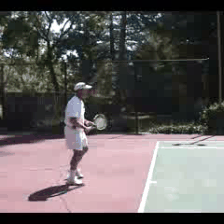

In [17]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])